# Hybrid Recommendation System

In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Load datasets
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

## Data Preprocessing

In [76]:
# Remove the year from movie titles (assumes year is in the format " (YYYY)" at the end)
movies['title'] = movies['title'].str[:-7]

# Display the first few rows of the movies dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [77]:
# Display the first few rows of the ratings dataset to inspect the structure
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [78]:
# Drop the 'timestamp' column from the filtered ratings dataframe as it's not needed
ratings = ratings.drop(columns='timestamp')

In [79]:
# Handling missing values
movies.fillna('', inplace=True)
ratings.fillna(0, inplace=True)

In [80]:
# Total no of movies in dataset that are unique
len(movies.movieId.unique()) 

9742

In [81]:
# Total no of unique ratings
print(len(ratings.userId.unique()))

610


In [82]:
# Replace pipe characters '|' in the genres column with spaces for easier text processing
movies['genres'] = movies['genres'].str.replace('|', ' ')

# Show the first 5 rows to verify changes
movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy


### Collaborative filtering preperation

In [83]:
# Filter users who have rated at least 55 movies to ensure enough data for collaborative filtering
ratings_filtered = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

# Print the total number of ratings and unique users after filtering
print(f"Total ratings after filtering: {len(ratings_filtered)}")
print(f"Number of unique users after filtering: {ratings_filtered['userId'].nunique()}")

# Extract the list of unique movie IDs present after filtering
filtered_movie_ids = ratings_filtered['movieId'].unique().tolist()

# Print the number of unique movies remaining after filtering
print(f"Number of unique movies after filtering: {len(filtered_movie_ids)}")

Total ratings after filtering: 92729
Number of unique users after filtering: 364
Number of unique movies after filtering: 9625


In [84]:
# Calculate and print the percentage of original movies that remain in the filtered ratings dataset
coverage_percent = (len(ratings['movieId'].unique()) / len(movies['movieId'].unique())) * 100
print(f"Coverage of movies in ratings data: {coverage_percent:.2f}%")

Coverage of movies in ratings data: 99.82%


In [85]:
# Calculate the percentage of users retained after filtering
user_retention_percent = (len(ratings_filtered['userId'].unique()) / len(ratings['userId'].unique())) * 100
print(f"User retention after filtering: {user_retention_percent:.2f}%")

User retention after filtering: 59.67%


In [86]:
# Filter the movies dataframe to keep only movies that appear in the filtered ratings list
movies = movies[movies['movieId'].isin(filtered_movie_ids)]

# Display the first few rows to verify the filtered movies dataframe
movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy


## metadata creation using 'genres' and 'tag' columns

In [87]:
# Merge movies and tags dataframes to create a combined overview for content comparison
# Using a left join to keep all movies, adding tags where available
mixed = pd.merge(movies, tags, on='movieId', how='left')

# Display the first 2 rows to verify the merged dataframe
mixed.head(2)

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story,Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09


In [88]:
# Replace NaN values in the 'tag' column with empty strings to avoid issues during concatenation
mixed['tag'] = mixed['tag'].fillna('')

# Concatenate all user tags for each movie into a single string
# Example: For movieId 1 (Toy Story), tags like 'Owned', 'imdb top 250', 'pixar' are combined
tags_combined = mixed.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge the concatenated tags back into the movies dataframe
final_df = pd.merge(movies, tags_combined, on='movieId', how='left')

# Fill NaNs in the new 'tag' column (in case some movies have no tags)
final_df['tag'] = final_df['tag'].fillna('')

# Create a new 'metadata' column by combining 'genres' and 'tag' for richer content representation
final_df['metadata'] = final_df[['genres', 'tag']].agg(' '.join, axis=1)

# Drop the original 'genres' and 'tag' columns as they're now merged into 'metadata'
final_df = final_df.drop(columns=['genres', 'tag'])

# Show the first few rows of the final dataframe
final_df.head()

,movieId,title,metadata
0,1,Toy Story,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men,Comedy Romance moldy old
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy pregnancy remake


In [89]:
# Display the shape of the final dataframe (rows x columns)
print(f"Final dataframe shape: {final_df.shape}")

Final dataframe shape: (9625, 3)


# Content based filtering

Creating a content latent matrix (basically Matrix Factorization) from movie metadata using

tf-idf vectors and truncated SVD (Singular value decomposition):


## TF-IDF

In [90]:
# Initialize TF-IDF Vectorizer with English stop words removed (e.g., "for", "and", "to", "or")
tfidf = TfidfVectorizer(stop_words='english')

# Transform the 'metadata' column into a TF-IDF weighted sparse matrix
# Each row corresponds to a movie; each column corresponds to a unique word/term
tfidf_matrix = tfidf.fit_transform(final_df['metadata'])

# Convert the sparse TF-IDF matrix to a dense DataFrame for easier inspection (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=final_df.index)

# Display the TF-IDF DataFrame
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Truncated SVD

The first 200 components explain over 80% of the variance

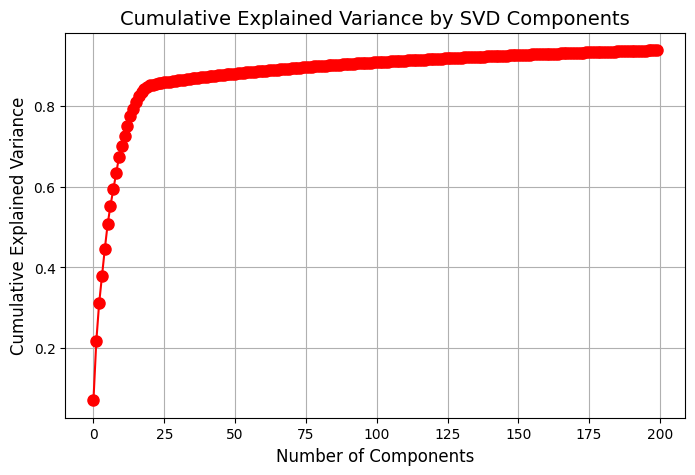

In [91]:
# Apply Truncated SVD to reduce dimensionality of the TF-IDF matrix to 200 components
svd = TruncatedSVD(n_components=200, random_state=42)
latent_matrix = svd.fit_transform(tfidf_df)

# Calculate cumulative explained variance to understand how much information is retained
explained_variance = svd.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance to find the "elbow" point
plt.figure(figsize=(8,5))
plt.plot(explained_variance, marker='.', markersize=16, color='red')
plt.title('Cumulative Explained Variance by SVD Components', fontsize=14)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.grid(True)
plt.show()

In [92]:
# Select the first 'n' latent dimensions from the SVD output for further analysis
n = 200

# Create a DataFrame of the reduced features with movie titles as the index for easy lookup
latent_matrix_1_df = pd.DataFrame(latent_matrix[:, :n], index=final_df['title'])

# Display the first few rows to verify
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,-0.234567,-0.019392,-0.124586,0.008614,...,0.067603,0.075882,0.040635,-0.064704,-0.015329,0.109717,0.027803,-0.083441,-0.078104,0.083466
Jumanji,0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,-0.189676,-0.012325,-0.078054,-0.001669,...,0.012591,-0.011168,0.004038,-0.000864,0.007110,0.003394,0.014100,-0.011663,-0.012987,-0.014286
Grumpier Old Men,0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,0.011973,0.000952,0.004727,0.002093,...,-0.000445,0.000461,-0.003754,-0.000333,-0.008339,-0.003265,-0.004076,0.002878,-0.002843,0.000594
Waiting to Exhale,0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,0.046063,0.001273,0.028399,0.000377,...,-0.000007,-0.000077,-0.000256,-0.000031,-0.000110,-0.000407,0.000005,-0.000250,-0.000625,-0.000124
Father of the Bride Part II,0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,0.009221,-0.001934,0.004463,0.011439,...,0.008240,-0.013009,0.006453,-0.023458,-0.002453,0.009098,-0.009635,-0.006441,-0.004145,0.015779


# Collaborative Filtering

Creating Latent Matrix For Collaborative Filtering From User Ratings

In [93]:
# Display the first 5 rows of the filtered ratings DataFrame to inspect its structure
ratings_filtered.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [94]:
# Merge filtered ratings with movies to ensure all ratings correspond to valid movies
# Using a right join to keep all entries from the filtered ratings dataframe
ratings_filtered_merged = pd.merge(movies[['movieId']], ratings_filtered, on='movieId', how='right')

# Print the shape of the merged dataframe (rows, columns)
print(f"Shape of merged ratings dataframe: {ratings_filtered_merged.shape}")

Shape of merged ratings dataframe: (92729, 3)


In [95]:
# Pivot the merged ratings dataframe to create a movie-user rating matrix
# Rows represent movies, columns represent users, and values are the ratings
# Fill missing ratings with 0 (indicating no rating)
ratings_pivot = ratings_filtered_merged.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# Display the shape to verify the size of the user-item matrix
print(f"User-item matrix shape: {ratings_pivot.shape}")

User-item matrix shape: (9625, 364)


In [96]:
# Print the shape of the user-item rating matrix (movies x users)
print(f"User-item matrix shape: {ratings_pivot.shape}")

# Display the first 5 rows of the user-item matrix to inspect rating distribution
ratings_pivot.head(5)

User-item matrix shape: (9625, 364)


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# Get the count of unique movies in the filtered ratings dataset
unique_movies_count = ratings_filtered['movieId'].nunique()
print(f"Number of unique movies in filtered ratings: {unique_movies_count}")

Number of unique movies in filtered ratings: 9625


In [98]:
# Apply Truncated SVD on the user-item rating matrix to reduce dimensionality
svd = TruncatedSVD(n_components=200, random_state=42)
latent_matrix_2 = svd.fit_transform(ratings_pivot)

# Create a DataFrame for the latent features with movie titles as the index
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=final_df['title'])

# Display the first few rows of the latent features dataframe
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,36.391240,-4.958788,-14.331820,-1.844157,3.077922,-1.351171,-8.341427,-0.561088,-1.898201,-1.657856,...,2.573335,-2.219093,0.721331,1.723421,0.432827,0.664067,1.300174,-0.608949,0.423808,1.477977
Jumanji,20.447499,0.675231,-11.354479,7.325453,3.505243,3.585611,-4.393396,-5.564559,0.434472,-0.351437,...,0.104838,-1.189002,0.490489,-0.095051,1.671810,-0.267968,-2.528653,-0.499201,-1.695338,-1.177249
Grumpier Old Men,8.407816,-5.190801,-4.378314,6.189039,0.333121,1.924149,1.548363,0.795946,-3.196045,-2.121791,...,-0.719714,-0.658326,-0.494370,0.471450,-0.849481,0.993000,0.562588,0.354839,0.419328,-0.837728
Waiting to Exhale,0.408037,-0.664700,-0.739903,0.202676,0.498374,1.055409,-0.184081,-0.508293,-0.429505,-0.086538,...,0.044678,0.326585,0.044359,0.270893,0.370802,-0.056020,-0.201080,-0.092331,-0.088901,0.198969
Father of the Bride Part II,5.755079,-1.757369,-3.961287,3.673278,3.688047,3.237859,-1.140585,-0.690786,-2.171826,-1.365962,...,0.496405,0.607806,0.066641,0.614844,-0.127757,0.134410,-0.214938,-0.874997,-0.053875,-0.243258


In [99]:
# Display the first 7 rows of the metadata latent feature dataframe
latent_matrix_1_df.head(7)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,-0.234567,-0.019392,-0.124586,0.008614,...,0.067603,0.075882,0.040635,-0.064704,-0.015329,0.109717,0.027803,-0.083441,-7.810371e-02,0.083466
Jumanji,0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,-0.189676,-0.012325,-0.078054,-0.001669,...,0.012591,-0.011168,0.004038,-0.000864,0.007110,0.003394,0.014100,-0.011663,-1.298696e-02,-0.014286
Grumpier Old Men,0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,0.011973,0.000952,0.004727,0.002093,...,-0.000445,0.000461,-0.003754,-0.000333,-0.008339,-0.003265,-0.004076,0.002878,-2.842610e-03,0.000594
Waiting to Exhale,0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,0.046063,0.001273,0.028399,0.000377,...,-0.000007,-0.000077,-0.000256,-0.000031,-0.000110,-0.000407,0.000005,-0.000250,-6.250272e-04,-0.000124
Father of the Bride Part II,0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,0.009221,-0.001934,0.004463,0.011439,...,0.008240,-0.013009,0.006453,-0.023458,-0.002453,0.009098,-0.009635,-0.006441,-4.145389e-03,0.015779
Heat,0.248284,-0.193538,0.723598,-0.199591,0.165240,-0.530794,0.063083,-0.000683,-0.003843,-0.063029,...,-0.000128,-0.000162,-0.000227,0.000057,0.000170,0.000273,-0.000046,0.000022,-6.423364e-07,0.000212
Sabrina,0.243798,0.172816,-0.068992,0.200344,0.162584,-0.065606,0.018927,0.001524,0.007730,0.004327,...,0.007353,-0.015013,0.007447,-0.016592,-0.011791,0.016323,0.006116,-0.023089,-1.298556e-02,0.026171


In [100]:
# Display the first 7 rows of the ratings latent feature dataframe
latent_matrix_2_df.head(7)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,36.391240,-4.958788,-14.331820,-1.844157,3.077922,-1.351171,-8.341427,-0.561088,-1.898201,-1.657856,...,2.573335,-2.219093,0.721331,1.723421,0.432827,0.664067,1.300174,-0.608949,0.423808,1.477977
Jumanji,20.447499,0.675231,-11.354479,7.325453,3.505243,3.585611,-4.393396,-5.564559,0.434472,-0.351437,...,0.104838,-1.189002,0.490489,-0.095051,1.671810,-0.267968,-2.528653,-0.499201,-1.695338,-1.177249
Grumpier Old Men,8.407816,-5.190801,-4.378314,6.189039,0.333121,1.924149,1.548363,0.795946,-3.196045,-2.121791,...,-0.719714,-0.658326,-0.494370,0.471450,-0.849481,0.993000,0.562588,0.354839,0.419328,-0.837728
Waiting to Exhale,0.408037,-0.664700,-0.739903,0.202676,0.498374,1.055409,-0.184081,-0.508293,-0.429505,-0.086538,...,0.044678,0.326585,0.044359,0.270893,0.370802,-0.056020,-0.201080,-0.092331,-0.088901,0.198969
Father of the Bride Part II,5.755079,-1.757369,-3.961287,3.673278,3.688047,3.237859,-1.140585,-0.690786,-2.171826,-1.365962,...,0.496405,0.607806,0.066641,0.614844,-0.127757,0.134410,-0.214938,-0.874997,-0.053875,-0.243258
Heat,21.147710,-6.162329,-7.098517,-2.507193,-6.830615,8.125510,5.282011,-0.279929,5.225559,-0.826434,...,0.529237,1.066461,-1.089665,1.577204,1.497869,-0.493655,0.710692,-1.034056,1.420120,-0.716524
Sabrina,6.168381,-4.654849,-3.343397,3.640084,4.642767,5.257256,0.176211,-0.764383,-0.495273,1.106930,...,-0.133539,0.199099,0.555536,0.068459,-0.065458,0.163809,-0.025801,0.299653,0.829855,-0.049238


In [101]:
# Print the shapes of metadata and ratings latent feature DataFrames
print(f"Metadata latent matrix shape: {latent_matrix_1_df.shape}")
print(f"Ratings latent matrix shape: {latent_matrix_2_df.shape}")

Metadata latent matrix shape: (9625, 200)
Ratings latent matrix shape: (9625, 200)


## Cosine Similarity

Running a content / collaborative and hybrid cosine similarity

In [102]:
# Select the latent vectors for the movie 'Die Hard' from both content-based and collaborative matrices
content_vec = np.array(latent_matrix_1_df.loc['Die Hard']).reshape(1, -1)
collab_vec = np.array(latent_matrix_2_df.loc['Die Hard']).reshape(1, -1)

# Calculate cosine similarity of 'Die Hard' with all other movies based on content features
content_scores = cosine_similarity(latent_matrix_1_df, content_vec).reshape(-1)

# Calculate cosine similarity of 'Die Hard' with all other movies based on collaborative features
collab_scores = cosine_similarity(latent_matrix_2_df, collab_vec).reshape(-1)

# Compute the hybrid similarity by averaging content-based and collaborative scores
hybrid_scores = (content_scores + collab_scores) / 2.0

# Create a DataFrame to hold similarity scores with movie titles as index
similarity_df = pd.DataFrame({
    'content': content_scores,
    'collaborative': collab_scores,
    'hybrid': hybrid_scores
}, index=final_df['title'])

# Sort movies by hybrid similarity score in descending order to get the most similar movies on top
similarity_df.sort_values('hybrid', ascending=False, inplace=True)

# Display the similarity DataFrame
similarity_df.head()

,content,collaborative,hybrid
title,,,
Die Hard,1.0,1.000000,1.000000
Die Hard: With a Vengeance,1.0,0.520592,0.760296
Heat,1.0,0.509844,0.754922
Ronin,1.0,0.506985,0.753492
"Bourne Supremacy, The",1.0,0.462361,0.731180


In [103]:
# Display the movies DataFrame to review movie information such as movieId, title, and genres
movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy


In [104]:
# Filter links DataFrame to keep only movies present in the filtered ratings
links_filtered = links[links['movieId'].isin(ratings_filtered['movieId'])]

# Merge the 'tmdbId' from the filtered links into the final_df DataFrame on 'movieId'
final_df = final_df.merge(links_filtered[['movieId', 'tmdbId']], on='movieId', how='left')

# Drop the original 'movieId' column from final_df
final_df.drop(columns=['movieId'], inplace=True)

# Rename 'tmdbId' column to 'movieId' in final_df for consistency
final_df.rename(columns={'tmdbId': 'movieId'}, inplace=True)

# Display the first 3 rows to verify changes
final_df.head(3)

,title,metadata,movieId
0,Toy Story,Adventure Animation Children Comedy Fantasy pi...,862.0
1,Jumanji,Adventure Children Fantasy fantasy magic board...,8844.0
2,Grumpier Old Men,Comedy Romance moldy old,15602.0


## Recommendation function

In [ ]:
def recommend(movie, rec_type=3, top_n=5):
    """
    Recommend movies similar to the given movie based on content, collaborative, or hybrid similarity.

    Parameters:
    - movie (str): The movie title to find recommendations for.
    - rec_type (int): Type of recommendation:
        1 = Content-based only
        2 = Collaborative filtering only
        3 = Hybrid (average of content and collaborative)
    - top_n (int): Number of top recommendations to return (default 5).
    """

    # Extract latent vectors for the selected movie from both matrices
    content_vec = np.array(latent_matrix_1_df.loc[movie]).reshape(1, -1)
    collab_vec = np.array(latent_matrix_2_df.loc[movie]).reshape(1, -1)

    # Calculate cosine similarity scores for all movies
    content_scores = cosine_similarity(latent_matrix_1_df, content_vec).reshape(-1)
    collab_scores = cosine_similarity(latent_matrix_2_df, collab_vec).reshape(-1)

    if rec_type == 1:
        # Content-based recommendations
        scores = content_scores
    elif rec_type == 2:
        # Collaborative filtering recommendations
        scores = collab_scores
    else:
        # Hybrid recommendations (average)
        scores = (content_scores + collab_scores) / 2.0

    # Sort scores in descending order and get indices
    sorted_indices = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)

    # Exclude the input movie itself from recommendations
    recommendations = [final_df.iloc[i[0]].title for i in sorted_indices if final_df.iloc[i[0]].title != movie]

    # Print top_n recommendations
    print(f"Top {top_n} recommendations for '{movie}' (type={rec_type}):")
    for title in recommendations[:top_n]:
        print(title)


In [106]:
# Content-based recommendations for 'Deadpool'
recommend('Deadpool', rec_type=1, top_n=5)

# Collaborative filtering recommendations for 'Deadpool'
recommend('Deadpool', rec_type=2, top_n=5)

# Hybrid recommendations for 'Deadpool' (default)
recommend('Deadpool', rec_type=3, top_n=5)

Top 5 recommendations for 'Deadpool' (type=1):
Fifth Element, The
Space Cowboys
Innerspace
Adventures of Pluto Nash, The
Last Starfighter, The
Top 5 recommendations for 'Deadpool' (type=2):
Mad Max: Fury Road
Star Wars: Episode VII - The Force Awakens
Edge of Tomorrow
Guardians of the Galaxy
John Wick
Top 5 recommendations for 'Deadpool' (type=3):
Ant-Man
Avengers: Age of Ultron
The Martian
X-Men: Days of Future Past
Guardians of the Galaxy 2


## Exporting preprocessed data

In [107]:
# Exporting preprocessed data and latent matrices for frontend use
pickle.dump(final_df, open("MovieRecommender/Final.pkl", "wb"))  # Final metadata DataFrame
pickle.dump(latent_matrix_1_df, open("MovieRecommender/content_latent_matrix.pkl", "wb"))  # Content-based latent features
pickle.dump(latent_matrix_2_df, open("MovieRecommender/collaborative_latent_matrix.pkl", "wb"))  # Collaborative latent features
pickle.dump(final_df['title'], open("MovieRecommender/movie_list.pkl", "wb"))  # List of movie titles

In [108]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

# Make sure latent_matrix_1_df and latent_matrix_2_df are indexed by movieId
latent_matrix_1_df.index = final_df['movieId']
latent_matrix_2_df.index = final_df['movieId']

# Also make a lookup from movieId to title
movie_id_to_title = dict(zip(final_df['movieId'], final_df['title']))
title_to_movie_id = dict(zip(final_df['title'], final_df['movieId']))


In [109]:
def precision_recall_f1_at_k(recommended, ground_truth, k=10):
    recommended = recommended[:k]
    ground_truth = set(ground_truth)
    recommended_set = set(recommended)

    true_positives = len(recommended_set & ground_truth)

    precision = true_positives / len(recommended) if recommended else 0
    recall = true_positives / len(ground_truth) if ground_truth else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1


In [111]:
def evaluate_hybrid(weights, user_sample, k=10):
    alpha = weights[0]  # weight for content-based
    beta = weights[1]   # weight for collaborative

    precision_list = []
    recall_list = []
    f1_list = []

    for user in user_sample:
        user_ratings = ratings_filtered[ratings_filtered['userId'] == user]
        if len(user_ratings) < k + 5:
            continue

        test_movies = user_ratings.sample(k)
        train_movies = user_ratings.drop(test_movies.index)

        liked_movies = train_movies.sort_values('rating', ascending=False).head(3)['movieId'].tolist()
        ground_truth = test_movies[test_movies['rating'] >= 4]['movieId'].tolist()

        if not ground_truth or not liked_movies:
            continue

        # Generate recommendations for the user
        scores = defaultdict(float)
        for movie in liked_movies:
            if movie not in latent_matrix_1_df.index or movie not in latent_matrix_2_df.index:
                continue

            content_vec = latent_matrix_1_df.loc[movie].values.reshape(1, -1)
            collab_vec = latent_matrix_2_df.loc[movie].values.reshape(1, -1)

            content_scores = cosine_similarity(latent_matrix_1_df, content_vec).reshape(-1)
            collab_scores = cosine_similarity(latent_matrix_2_df, collab_vec).reshape(-1)

            hybrid_scores = alpha * content_scores + beta * collab_scores

            for idx, score in zip(latent_matrix_1_df.index, hybrid_scores):
                scores[idx] += score

        # Remove already seen movies
        seen = set(train_movies['movieId'])
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        recommended = [movie_id for movie_id, score in sorted_scores if movie_id not in seen][:k]

        precision, recall, f1 = precision_recall_f1_at_k(recommended, ground_truth, k)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


In [114]:
import random

# Sample 100 users for evaluation
user_sample = random.sample(ratings_filtered['userId'].unique().tolist(), 300)

# Try different weight combinations
weight_options = [(round(i/10,1), round(1-i/10,1)) for i in range(0,11)]

results = []

for w in weight_options:
    precision, recall, f1 = evaluate_hybrid(w, user_sample, k=10)
    results.append((w, precision, recall, f1))
    print(f"Weights (Content: {w[0]}, Collaborative: {w[1]}) -> P@10: {precision:.4f}, R@10: {recall:.4f}, F1@10: {f1:.4f}")


Weights (Content: 0.0, Collaborative: 1.0) -> P@10: 0.0010, R@10: 0.0017, F1@10: 0.0013
Weights (Content: 0.1, Collaborative: 0.9) -> P@10: 0.0007, R@10: 0.0013, F1@10: 0.0009
Weights (Content: 0.2, Collaborative: 0.8) -> P@10: 0.0007, R@10: 0.0011, F1@10: 0.0008
Weights (Content: 0.3, Collaborative: 0.7) -> P@10: 0.0003, R@10: 0.0011, F1@10: 0.0005
Weights (Content: 0.4, Collaborative: 0.6) -> P@10: 0.0014, R@10: 0.0021, F1@10: 0.0016
Weights (Content: 0.5, Collaborative: 0.5) -> P@10: 0.0007, R@10: 0.0014, F1@10: 0.0009
Weights (Content: 0.6, Collaborative: 0.4) -> P@10: 0.0007, R@10: 0.0012, F1@10: 0.0009
Weights (Content: 0.7, Collaborative: 0.3) -> P@10: 0.0003, R@10: 0.0006, F1@10: 0.0004
Weights (Content: 0.8, Collaborative: 0.2) -> P@10: 0.0010, R@10: 0.0017, F1@10: 0.0012
Weights (Content: 0.9, Collaborative: 0.1) -> P@10: 0.0003, R@10: 0.0006, F1@10: 0.0004
Weights (Content: 1.0, Collaborative: 0.0) -> P@10: 0.0000, R@10: 0.0000, F1@10: 0.0000


In [115]:
best_weights = max(results, key=lambda x: x[3])  # based on F1@10
print(f"\nBest Weights (Content, Collaborative): {best_weights[0]} with F1@10 = {best_weights[3]:.4f}")



Best Weights (Content, Collaborative): (0.4, 0.6) with F1@10 = 0.0016
